## Rain prediction in Australia

#### Import required libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import sklearn

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

import optuna

import xgboost as xgb
from xgboost import XGBClassifier

import joblib

<br>
<br>
<br>
<br>
<br>

#### Read dataset

In [29]:
dataframe_clean_wo_outl_wo_corr = pd.read_csv(r"C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\1- Data\2- Processed\dataframe_clean_wo_outl_wo_corr.csv", index_col=0)
dataframe_clean_wo_outl_wo_corr.head()

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,Albury,0.6,W,44.0,W,WNW,71.0,22.0,1007.7,0.0,0.0
1,Albury,0.0,WNW,44.0,NNW,WSW,44.0,25.0,1010.6,0.0,0.0
2,Albury,0.0,WSW,46.0,W,WSW,38.0,30.0,1007.6,0.0,0.0
3,Albury,0.0,NE,24.0,SE,E,45.0,16.0,1017.6,0.0,0.0
4,Albury,1.0,W,41.0,ENE,NW,82.0,33.0,1010.8,0.0,0.0


dataframe_clean_wo_outl_wo_corr characteristics:
- Removed univariated outliers
- Removed variables with high collinearity

<br>
<br>
<br>
<br>
<br>

#### Encode Categorical Features

In [30]:
dataframe_encoded = pd.get_dummies(dataframe_clean_wo_outl_wo_corr)
dataframe_encoded.head()

,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.6,44.0,71.0,22.0,1007.7,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.0,44.0,44.0,25.0,1010.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,46.0,38.0,30.0,1007.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.0,24.0,45.0,16.0,1017.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,41.0,82.0,33.0,1010.8,0.0,0.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


<br>
<br>
<br>
<br>
<br>

## Model Tranining

#### Create X and y dataframes

In [31]:
X = dataframe_encoded[[c for c in dataframe_encoded if c != 'RainTomorrow']].values
y = dataframe_encoded[['RainTomorrow']]

In [32]:
#y must be unidimensional array
y = np.ravel(y)

#### Create SMOTE and Scaler out of objective function

In [34]:
smote = SMOTE(random_state=42)
scaler = MinMaxScaler()

#### Define objective function

In [35]:
def objective(trial):
    # Aplicar SMOTE al conjunto de entrenamiento
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Aplicar MinMaxScaler a los datasets
    X_scaled = scaler.fit_transform(X_resampled)

    # Definir parámetros para la optimización
    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'eval_metric': 'error',
    }

    param["booster"] == "gbtree"
    param["subsample"] = trial.suggest_float("subsample", 1e-8, 1.0, log=True)
    param["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)        
    param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    # Crear y entrenar el modelo con el conjunto resampleado y escalado
    model = XGBClassifier(**param)
    scores = cross_val_score(model, X_scaled, y_resampled, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

    # Retornar la media de las puntuaciones (negativas)
    return -scores.mean()

#### Split dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Create Optuna study

In [37]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2023-11-28 21:58:00,292] A new study created in memory with name: no-name-dd46bffa-c508-4c72-b26d-c34070bdbf20
[I 2023-11-28 21:58:16,912] Trial 0 finished with value: -0.5 and parameters: {'booster': 'gbtree', 'lambda': 1.381751317787803e-06, 'alpha': 5.477449085657667e-05, 'subsample': 1.947275407577936e-06, 'n_estimators': 41, 'max_depth': 20, 'eta': 4.548935158231754e-06, 'gamma': 0.2953686839240671, 'grow_policy': 'lossguide'}. Best is trial 0 with value: -0.5.
[I 2023-11-28 21:59:37,973] Trial 1 finished with value: -0.8528891908648367 and parameters: {'booster': 'gbtree', 'lambda': 3.490344144458071e-07, 'alpha': 2.5716828295135485e-05, 'subsample': 0.11002372957720967, 'n_estimators': 44, 'max_depth': 10, 'eta': 0.005852051274760399, 'gamma': 3.8819663532056654e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: -0.8528891908648367.
[I 2023-11-28 22:00:12,332] Trial 2 finished with value: -0.5 and parameters: {'booster': 'gbtree', 'lambda': 6.4007945086342885e-06, 

KeyboardInterrupt: 

#### Save best parameters

In [40]:
best_params = study.best_params

#### Apply SMOTE and Scaler to train dataset 

In [41]:
# Aplicar SMOTE al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Aplicar MinMaxScaler a los datasets
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

#### Create model with best parameters

In [42]:
best_model = XGBClassifier(**best_params)

#### Train model with resampled dataset

In [43]:
best_model.fit(X_train_scaled, y_train_resampled)

XGBClassifier(alpha=2.5716828295135485e-05, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.005852051274760399,
              eval_metric=None, gamma=3.8819663532056654e-05, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=3.490344144458071e-07,
              learning_rate=0.00585205108, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=44, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

<br>
<br>
<br>
<br>

#### Prediction

In [44]:
y_pred = best_model.predict(X_test_scaled)

### Evaluate the model

In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)

Confusion Matrix:
 [[29902  4163]
 [ 3571  5963]]
Accuracy: 0.8226106103350994
Precision: 0.5888801106063599
Recall: 0.6254457730228655
F1-Score: 0.6066124109867752
ROC AUC: 0.7516191143112274


In [47]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    '''
    This function plots
    confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [48]:
def plot_classification_report(y_true, y_pred, title='Classification Report'):
    '''
    This function plots
    classification report
    '''
    report = classification_report(y_true, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(title)
    plt.show()

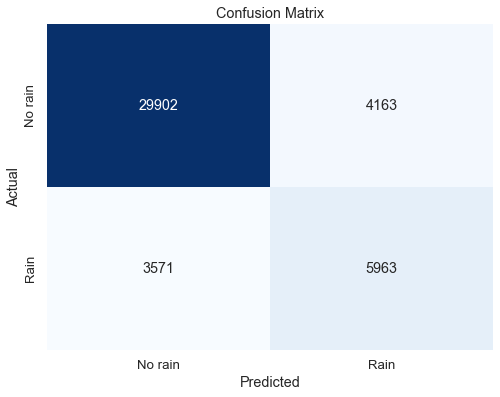

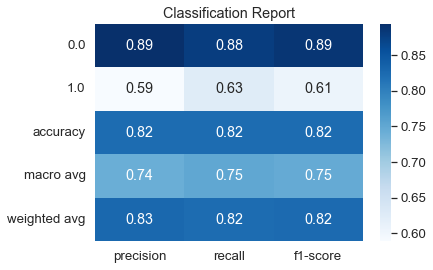

In [49]:
classes = ['No rain', 'Rain']

#Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes, title='Confusion Matrix')


#Classification report
plot_classification_report(y_test, y_pred, title='Classification Report')

#### ROC curve

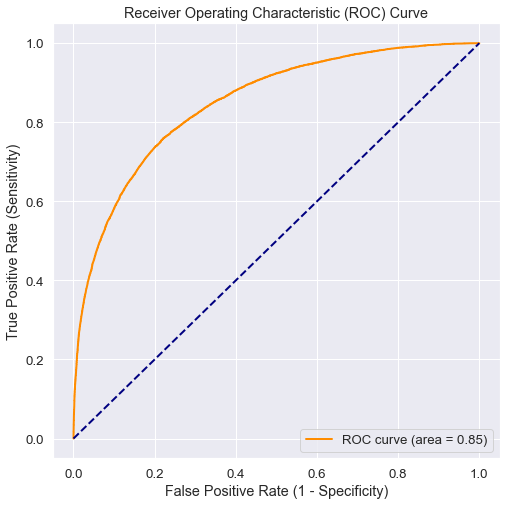

In [51]:
y_probabilities = best_model.predict_proba(X_test_scaled)[:, 1] #Probabilities of positives

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities) #Fail positive rate and true positive rate

roc_auc = auc(fpr, tpr) #Area under ROC curve

#Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<br>
<br>
<br>
<br>
<br>

In [54]:
# Obtener las probabilidades de clase para la clase positiva
y_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]  # Reemplaza 'X_test' con tus datos de prueba

# Definir una serie de umbrales
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

# Evaluar el rendimiento del modelo para cada umbral
for threshold in thresholds:
    y_predictions = (y_probabilities > threshold).astype(int)
    
    # Calcular y mostrar métricas de rendimiento (por ejemplo, precisión, recall, F1-score)
    precision = precision_score(y_test, y_predictions)
    recall = recall_score(y_test, y_predictions)
    f1 = f1_score(y_test, y_predictions)
    
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

Threshold: 0.20 | Precision: 0.2187 | Recall: 1.0000 | F1-score: 0.3589
Threshold: 0.25 | Precision: 0.2187 | Recall: 1.0000 | F1-score: 0.3589
Threshold: 0.30 | Precision: 0.2187 | Recall: 1.0000 | F1-score: 0.3589
Threshold: 0.35 | Precision: 0.2187 | Recall: 1.0000 | F1-score: 0.3589
Threshold: 0.40 | Precision: 0.2453 | Recall: 0.9931 | F1-score: 0.3935
Threshold: 0.45 | Precision: 0.4394 | Recall: 0.8121 | F1-score: 0.5702
Threshold: 0.50 | Precision: 0.5889 | Recall: 0.6254 | F1-score: 0.6066
Threshold: 0.55 | Precision: 0.7445 | Recall: 0.4122 | F1-score: 0.5306
Threshold: 0.60 | Precision: 0.9251 | Recall: 0.0867 | F1-score: 0.1586
Threshold: 0.65 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000


C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precis

Threshold: 0.70 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
Threshold: 0.75 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
Threshold: 0.80 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
Threshold: 0.85 | Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000


C:\Users\Lucio\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Best threshold seems to be 0.45

In [58]:
# Obtén las probabilidades predichas
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Aplica tu umbral personalizado (0.45 en este caso)
umbral = 0.53
y_predicted = (y_pred_proba > umbral).astype(int)

<br>
<br>
<br>
<br>
<br>

#### Save model

In [20]:
'''
ubi = r'C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\3- Models/XGBClf_rain_pred_CV.joblib'

joblib.dump(model, ubi)
'''

['C:\\Users\\Lucio\\Documents\\Github\\Next-day-rain-prediction\\3- Models/XGBClf_rain_pred.joblib']